In [1]:
import pandas as pd
import numpy as np
import os 
from datetime import datetime, timedelta, date
#import pyodbc
import matplotlib.pyplot as plt
import plotly.express as px
pd.options.plotting.backend = "plotly"
pd.set_option('display.max_columns', 150, 'display.max_rows', 100, 'display.max_colwidth', 15)

%matplotlib inline
# get directory address


# Intorduction

We have a dataset for a company that sells COVID tests at different locations. 

Customers book a test online and go to one of the testing sites to get tested.

The data includes the amount paid for different types of tests, the postcode of the customer, the site postcode where the test is booked, customer ID, age, and the date of the test.

We will create a feature using the site postcode and the customer postcode to calculate the travel distance between the site and the customer's residence. We will also create a feature based on the date of the last test purchase.

We will create clusters based on the amount paid, income, travel distance, age, and latest purchase. 

These clusters will be useful for marketing purposes as they can help identify high-income area customers, customers who live near testing sites, and those who spend more.

In conclusion, these clusters will be helpful in targeted marketing efforts to specific customer segments.

## Load Data

In [2]:
df_0= pd.read_csv("/Users/waleedidrees/Dropbox/Python_Projects/My_Projects/clustering/retail_data.csv",index_col=0).dropna().drop(columns=["population", "booking_horizon"])
df_0

,date_of_test,amount_paid,age,income,postcode,post_code,cus_id
57789,2022-01-18,66.67,65.0,52300.0,al10 0xr,al1 1bh,176343.0
57790,2022-01-11,119.00 (119...,62.0,68900.0,tw6 1ew,al1 1bz,176339.0
57791,2022-01-12,29.17,32.0,68900.0,tw6 1ew,al1 1bz,176337.0
57792,2022-01-01,49.17,26.0,68900.0,nw4 3fb,al1 1dh,70129.0
57793,2022-01-01,49.17,28.0,68900.0,nw4 3fb,al1 1dh,70129.0
...,...,...,...,...,...,...,...
365048,2022-01-11,29.17,34.0,31800.0,b26 3qj,b16 0pf,14262.0
365050,2022-01-09,29.17,49.0,64400.0,tw6 1qg,kt4 7db,7788.0
365051,2022-01-09,66.67,36.0,52000.0,al10 0xr,en6 1sw,129683.0
365053,2022-01-10,29.17,52.0,55800.0,rg2 0fl,sl6 4dg,44292.0


In [3]:
pd.DataFrame(df_0.dtypes).T

,date_of_test,amount_paid,age,income,postcode,post_code,cus_id
0,object,object,float64,float64,object,object,float64


In [4]:
df_0.shape

(111252, 7)

## Check for any missing values

In [5]:
df_0.isna().sum().to_frame("nulls").T

,date_of_test,amount_paid,age,income,postcode,post_code,cus_id
nulls,0,0,0,0,0,0,0


### Data cleaning decisions
* postcode is Site postcode and post_code is customer postcode

### wrangle and clean colums above
* clean amount paid
* rename postcode to site_postcode and post_code to cus_postcode
* remove spaces between the postcodes
* only filter out the UK postcodes

In [6]:
uk_postcode_pattern = r"\b([A-Za-z]{1,2}[0-9Rr][0-9A-Za-z]? [0-9][ABD-HJLNP-UW-Zabd-hjlnp-uw-z]{2})\b"
uk_postcode_pattern_no_space = r"\b([A-Za-z]{1,2}[0-9Rr][0-9A-Za-z]{0,1}[0-9][ABD-HJLNP-UW-Zabd-hjlnp-uw-z]{2})\b"

In [7]:

df_cus= (
    df_0
    .assign(
        date= lambda df_:  pd.to_datetime(df_.date_of_test),         
        amount_paid = lambda df_: df_['amount_paid'].str.split(" ", expand = True)[0].str.replace("£", "").str.replace('cash|re-test|paypal|vou-13687064', "NaN", regex=True).astype("float"),        
        site_postcode = lambda df_: df_.postcode.str.replace(" ",""),
        post_code = lambda df_: df_.post_code.str.replace(" ", ""),        
        # uk only postcodes using regex provided by uk postcode site
        cus_postcode= lambda df_: df_.post_code.str.extract(uk_postcode_pattern_no_space),                
        nat_int_pc = lambda df_: np.where(~df_.cus_postcode.isna(),"uk","int")                
            )        
    .query('nat_int_pc == "uk"')    
    .drop(columns = ["date_of_test", "postcode", "post_code", "nat_int_pc"])        
    .dropna()
    )
df_cus.head()

,amount_paid,age,income,cus_id,date,site_postcode,cus_postcode
57789,66.67,65.0,52300.0,176343.0,2022-01-18,al100xr,al11bh
57790,119.00,62.0,68900.0,176339.0,2022-01-11,tw61ew,al11bz
57791,29.17,32.0,68900.0,176337.0,2022-01-12,tw61ew,al11bz
57792,49.17,26.0,68900.0,70129.0,2022-01-01,nw43fb,al11dh
57793,49.17,28.0,68900.0,70129.0,2022-01-01,nw43fb,al11dh


In [8]:
df_cus.describe()

,amount_paid,age,income,cus_id
count,111252.000000,111252.000000,111252.000000,111252.000000
mean,54.192524,42.629067,49980.677201,98722.578138
std,24.553323,17.667990,10401.039633,78948.381404
min,0.000000,0.000000,20000.000000,2.000000
25%,40.000000,29.000000,43000.000000,25023.000000
50%,55.200000,42.000000,50100.000000,74309.500000
75%,57.500000,56.000000,57100.000000,173556.250000
max,189.000000,121.000000,85200.000000,253343.000000


# Prepare data to join lat long_points

### Download lat long point data

In [9]:
df_postcode= pd.read_csv("/Users/waleedidrees/Dropbox/Python_Projects/My_Projects/data_wrangle/data_lat_long.csv", index_col=0)
df_postcode.head()

,PCD,X_Latitude,Y_Longitude
0,AB10 1AB,57.149606,-2.096916
1,AB10 1AF,57.148707,-2.097806
2,AB10 1AG,57.148232,-2.096648
3,AB10 1AH,57.148081,-2.094664
4,AB10 1AJ,57.148430,-2.097970


### wrangle lat long data
* rename to lower lower letters
* rename columns
* convert postcodes to lower letters
* replace empty spaces from postcodes
* convert lat long to float

In [10]:
# convert postcodes to smaller letters and remove spaces
df_postcode=(  
    df_postcode
    .rename(columns= lambda df_: str.lower(df_) )
    .assign(
        pcd = lambda df_: df_.pcd.str.lower().str.replace(" ","")
           )
    .rename(columns={"pcd":"postcode","x_latitude":"latitude","y_longitude":"longitude"})
    .assign(
    latitude = lambda df_: df_.latitude.astype("float"),
    longitude = lambda df_: df_.longitude.astype("float")
    )
)

df_postcode.head()

,postcode,latitude,longitude
0,ab101ab,57.149606,-2.096916
1,ab101af,57.148707,-2.097806
2,ab101ag,57.148232,-2.096648
3,ab101ah,57.148081,-2.094664
4,ab101aj,57.148430,-2.097970


In [11]:
### Join lat long to cus data
df_dis=(
pd.merge(
    df_cus, df_postcode,
    how = "left",
    left_on = "site_postcode",
    right_on = "postcode"
    )
.rename(columns= {"latitude":"site_lat","longitude":"site_long"})
.drop(columns = ['site_postcode', "cus_postcode", "postcode"])
.reset_index(drop = True)
).merge(
 pd.merge(
     df_cus, df_postcode,
     how = "left",
     left_on = "cus_postcode",
     right_on = "postcode"
     )
 .rename(columns= {"latitude":"cus_lat","longitude":"cus_long"})
 .drop(columns = ['site_postcode', "cus_postcode", "postcode"])
 .reset_index(drop = True)
 ).dropna()

df_dis.head()

,amount_paid,age,income,cus_id,date,site_lat,site_long,cus_lat,cus_long
0,66.67,65.0,52300.0,176343.0,2022-01-18,51.761346,-0.240381,51.74685,-0.338000
1,119.00,62.0,68900.0,176339.0,2022-01-11,51.469706,-0.449579,51.75037,-0.340320
2,29.17,32.0,68900.0,176337.0,2022-01-12,51.469706,-0.449579,51.75037,-0.340320
3,49.17,26.0,68900.0,70129.0,2022-01-01,51.576416,-0.223792,51.74752,-0.341974
4,49.17,28.0,68900.0,70129.0,2022-01-01,51.576416,-0.223792,51.74752,-0.341974


### Calculate distance between custmer and site

In [12]:
# calculate distance 
#!pip install mpu
import mpu
def dis_calc(lat1,long1,lat2,long2):
    df_km= mpu.haversine_distance( (lat1, long1), (lat2,long2) )
    return df_km
    
df_dis["travel_dis"]= pd.Series(map(dis_calc, df_dis.cus_lat, df_dis.cus_long, df_dis.site_lat, df_dis.site_long)).round(2)

df_dis#.head()

,amount_paid,age,income,cus_id,date,site_lat,site_long,cus_lat,cus_long,travel_dis
0,66.67,65.0,52300.0,176343.0,2022-01-18,51.761346,-0.240381,51.74685,-0.338000,6.91
1,119.00,62.0,68900.0,176339.0,2022-01-11,51.469706,-0.449579,51.75037,-0.340320,32.11
2,29.17,32.0,68900.0,176337.0,2022-01-12,51.469706,-0.449579,51.75037,-0.340320,32.11
3,49.17,26.0,68900.0,70129.0,2022-01-01,51.576416,-0.223792,51.74752,-0.341974,20.70
4,49.17,28.0,68900.0,70129.0,2022-01-01,51.576416,-0.223792,51.74752,-0.341974,20.70
...,...,...,...,...,...,...,...,...,...,...
115759,29.17,34.0,31800.0,14262.0,2022-01-11,52.451284,-1.731063,52.48512,-1.949829,15.29
115760,29.17,49.0,64400.0,7788.0,2022-01-09,51.470836,-0.458283,51.37081,-0.251098,18.17
115761,66.67,36.0,52000.0,129683.0,2022-01-09,51.761346,-0.240381,51.70414,-0.179892,7.60
115762,29.17,52.0,55800.0,44292.0,2022-01-10,51.422324,-0.983497,51.51892,-0.730854,20.53


## Final Data

### Replace all travel_dis to 0 where site_postcode is empty
* and remove empty values

In [13]:
df_final=(
    df_dis    
    .drop(columns = ['site_lat','site_long', 'cus_lat', 'cus_long' ])                   

).copy()
df_final.head()

,amount_paid,age,income,cus_id,date,travel_dis
0,66.67,65.0,52300.0,176343.0,2022-01-18,6.91
1,119.00,62.0,68900.0,176339.0,2022-01-11,32.11
2,29.17,32.0,68900.0,176337.0,2022-01-12,32.11
3,49.17,26.0,68900.0,70129.0,2022-01-01,20.70
4,49.17,28.0,68900.0,70129.0,2022-01-01,20.70


In [14]:
df_final.describe(include= "all", datetime_is_numeric=True).T

,count,mean,min,25%,50%,75%,max,std
amount_paid,115764.0,54.316542,0.0,40.0,55.2,57.5,189.0,24.772003
age,115764.0,42.697687,0.0,29.0,42.0,56.0,121.0,17.71507
income,115764.0,50026.349297,20000.0,43100.0,50100.0,57200.0,85200.0,10399.290908
cus_id,115764.0,95907.06153,2.0,22991.75,69196.0,169422.25,253343.0,78766.799592
date,115764,2022-01-13 ...,2022-01-01 ...,2022-01-05 ...,2022-01-11 ...,2022-01-21 ...,2022-01-31 ...,NaN
travel_dis,115764.0,45.362715,0.0,7.31,17.28,40.58,658.35,69.451968


## EDA
    * We can check correlation now as thanks to ordinal encoder all catergorical data is also in numeric form
    * We can check pairplots now as thanks to ordinal encoder all catergorical data is also in numeric form

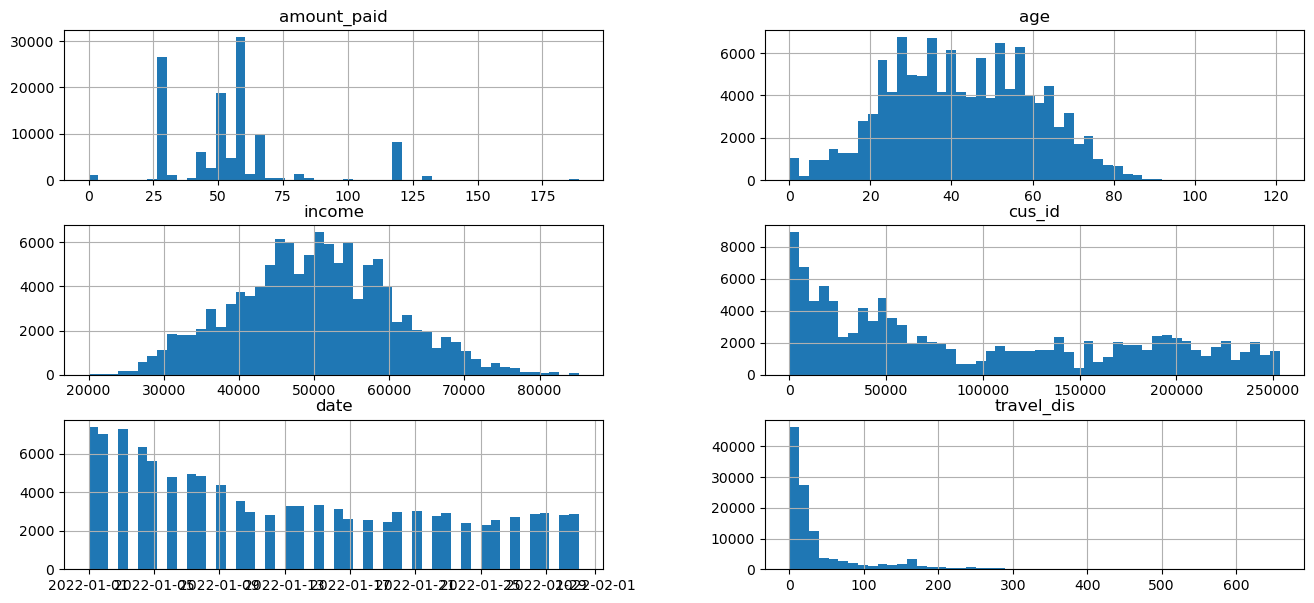

In [15]:
pd.options.plotting.backend = "matplotlib"
df_final.hist(
    bins=50, 
    figsize=(16,7)   
    )
plt.show()
pd.options.plotting.backend = "plotly"

# Find and Remove Outliers

In [16]:
from sklearn.ensemble import IsolationForest
model = IsolationForest(n_estimators=1000, contamination='auto', random_state=42)
model.fit(df_final.drop(columns=["date", "cus_id"]))

IsolationForest(n_estimators=1000, random_state=42)

In [17]:
predictions = model.predict(df_final.drop(columns=["date", "cus_id"]))
# add the predictions to the dataframe
df_final['outlier'] = predictions
df_final.head()

,amount_paid,age,income,cus_id,date,travel_dis,outlier
0,66.67,65.0,52300.0,176343.0,2022-01-18,6.91,1
1,119.00,62.0,68900.0,176339.0,2022-01-11,32.11,-1
2,29.17,32.0,68900.0,176337.0,2022-01-12,32.11,1
3,49.17,26.0,68900.0,70129.0,2022-01-01,20.70,1
4,49.17,28.0,68900.0,70129.0,2022-01-01,20.70,1


In [18]:
df_final[df_final['outlier'] == -1]

,amount_paid,age,income,cus_id,date,travel_dis,outlier
1,119.00,62.0,68900.0,176339.0,2022-01-11,32.11,-1
9,0.00,32.0,51500.0,15.0,2022-01-10,5.76,-1
10,0.00,32.0,51500.0,15.0,2022-01-28,5.76,-1
11,119.00,64.0,65900.0,70135.0,2022-01-28,32.70,-1
62,0.00,57.0,52300.0,176185.0,2022-01-14,7.17,-1
...,...,...,...,...,...,...,...
115734,189.00,28.0,57000.0,129631.0,2022-01-01,8.70,-1
115739,29.17,39.0,53700.0,129690.0,2022-01-10,511.30,-1
115740,29.17,30.0,68400.0,50445.0,2022-01-10,65.19,-1
115748,119.00,18.0,54200.0,46799.0,2022-01-26,15.19,-1


In [19]:
df_final = df_final[df_final['outlier'] != -1]
df_final.head()

,amount_paid,age,income,cus_id,date,travel_dis,outlier
0,66.67,65.0,52300.0,176343.0,2022-01-18,6.91,1
2,29.17,32.0,68900.0,176337.0,2022-01-12,32.11,1
3,49.17,26.0,68900.0,70129.0,2022-01-01,20.70,1
4,49.17,28.0,68900.0,70129.0,2022-01-01,20.70,1
5,64.00,36.0,51500.0,176333.0,2022-01-08,6.18,1


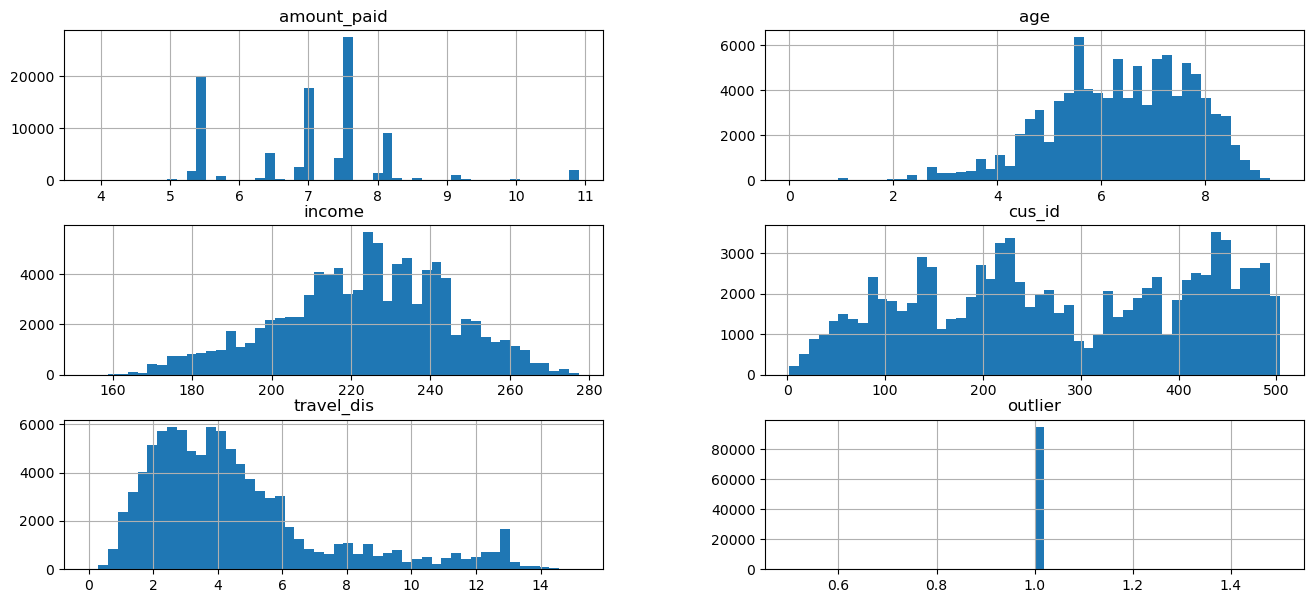

In [20]:
pd.options.plotting.backend = "matplotlib"
df_final.select_dtypes(["int", float]).apply(lambda df_:np.sqrt(df_)).hist(
    bins=50, 
    figsize=(16,7)   
    )
plt.show()
pd.options.plotting.backend = "plotly"

## Create latest purchase column

In [21]:
df=(
    df_final
    .sort_values(["cus_id","date"], ascending= True)    
    .assign(
        max_date= max(df_final.date),
        diff_days= lambda df_: (df_.max_date - df_.date).dt.days,       
    )   
)
df

,amount_paid,age,income,cus_id,date,travel_dis,outlier,max_date,diff_days
45085,119.00,54.0,46600.0,5.0,2022-01-17,11.53,1,2022-01-31,14
74200,119.00,39.0,51300.0,5.0,2022-01-25,6.63,1,2022-01-31,6
86575,119.00,31.0,49900.0,5.0,2022-01-25,4.55,1,2022-01-31,6
86574,119.00,31.0,49900.0,5.0,2022-01-29,4.55,1,2022-01-31,2
104086,69.00,40.0,51100.0,9.0,2022-01-01,38.16,1,2022-01-31,30
...,...,...,...,...,...,...,...,...,...
46380,66.67,31.0,38100.0,253238.0,2022-01-08,3.36,1,2022-01-31,23
46382,57.50,72.0,40200.0,253240.0,2022-01-06,3.86,1,2022-01-31,25
46383,57.50,35.0,40200.0,253241.0,2022-01-02,3.75,1,2022-01-31,29
46385,66.67,59.0,36800.0,253243.0,2022-01-04,4.92,1,2022-01-31,27


In [22]:
df=(df.merge(df.groupby("cus_id").agg(latest_purchase= pd.NamedAgg("diff_days", "min")).reset_index(),
    how="left",
    on = "cus_id")
    .drop(columns=["max_date", "date", "diff_days", "outlier"])
)
df

,amount_paid,age,income,cus_id,travel_dis,latest_purchase
0,119.00,54.0,46600.0,5.0,11.53,2
1,119.00,39.0,51300.0,5.0,6.63,2
2,119.00,31.0,49900.0,5.0,4.55,2
3,119.00,31.0,49900.0,5.0,4.55,2
4,69.00,40.0,51100.0,9.0,38.16,30
...,...,...,...,...,...,...
94847,66.67,31.0,38100.0,253238.0,3.36,23
94848,57.50,72.0,40200.0,253240.0,3.86,25
94849,57.50,35.0,40200.0,253241.0,3.75,29
94850,66.67,59.0,36800.0,253243.0,4.92,27


In [23]:
df=(
    df
    .groupby(["cus_id"])
    .mean(numeric_only= True)
    .reset_index()
    .drop(columns=[
        "cus_id"
        ])
)
df.head()

,amount_paid,age,income,travel_dis,latest_purchase
0,119.0,38.75,49425.0,6.815,2.0
1,69.0,40.00,51100.0,38.160,30.0
2,119.0,43.00,58000.0,18.470,1.0
3,57.5,38.00,54850.0,11.690,22.0
4,119.0,51.00,50200.0,14.450,8.0


# Calcualte mean values

<AxesSubplot: >

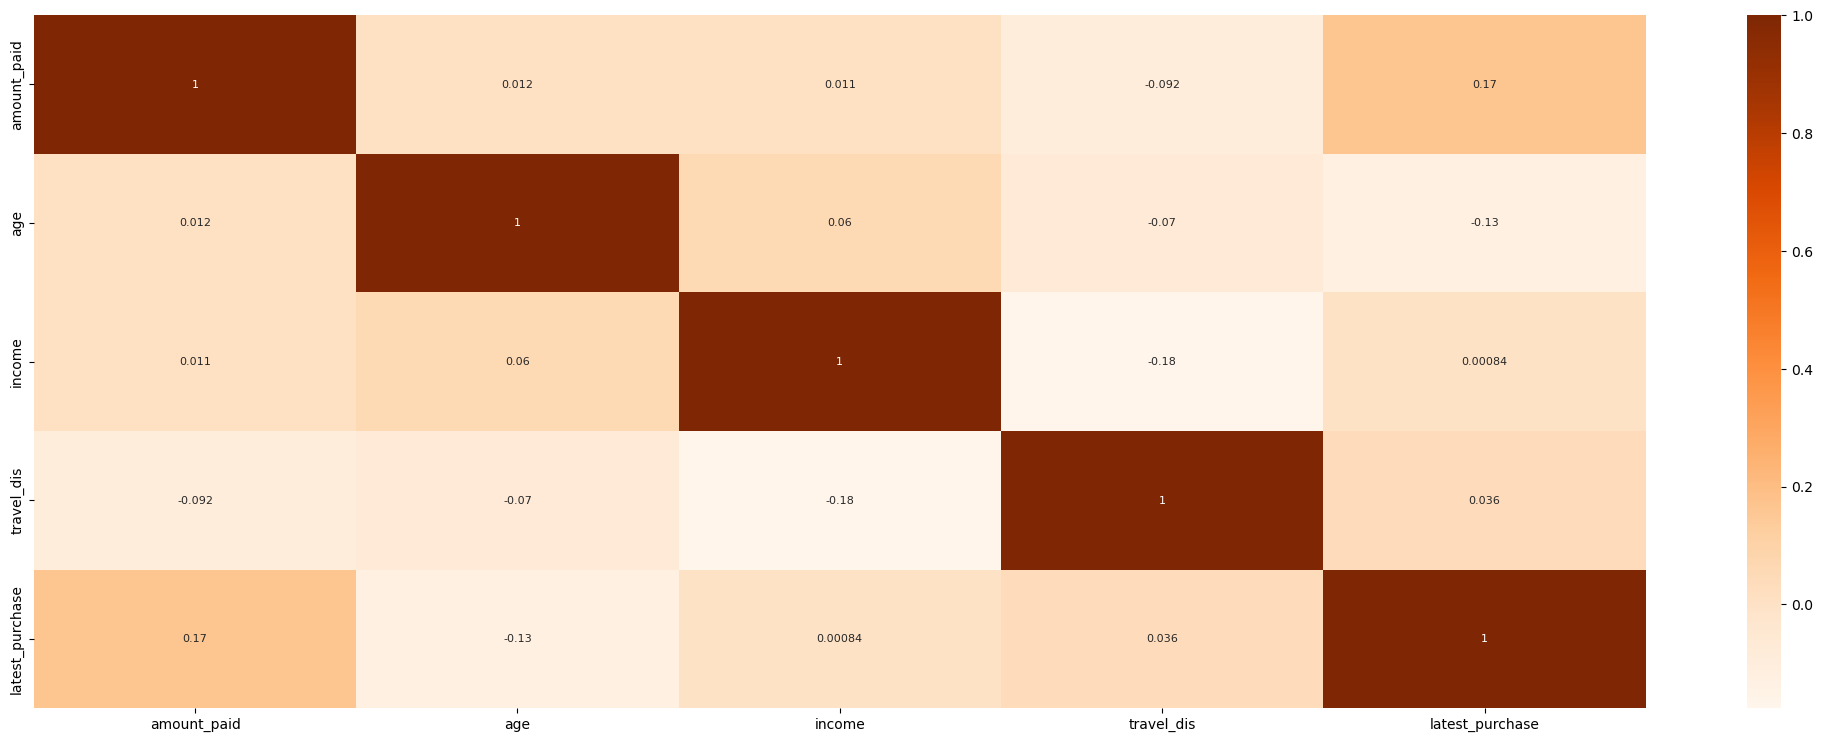

In [24]:
import seaborn as sns
df_corr =df.corr()
df_corr
fig, ax = plt.subplots(1,1,figsize=(26,9))
sns.heatmap(df_corr, cmap= "Oranges" , annot=True, annot_kws={"fontsize":8}, ax=ax)

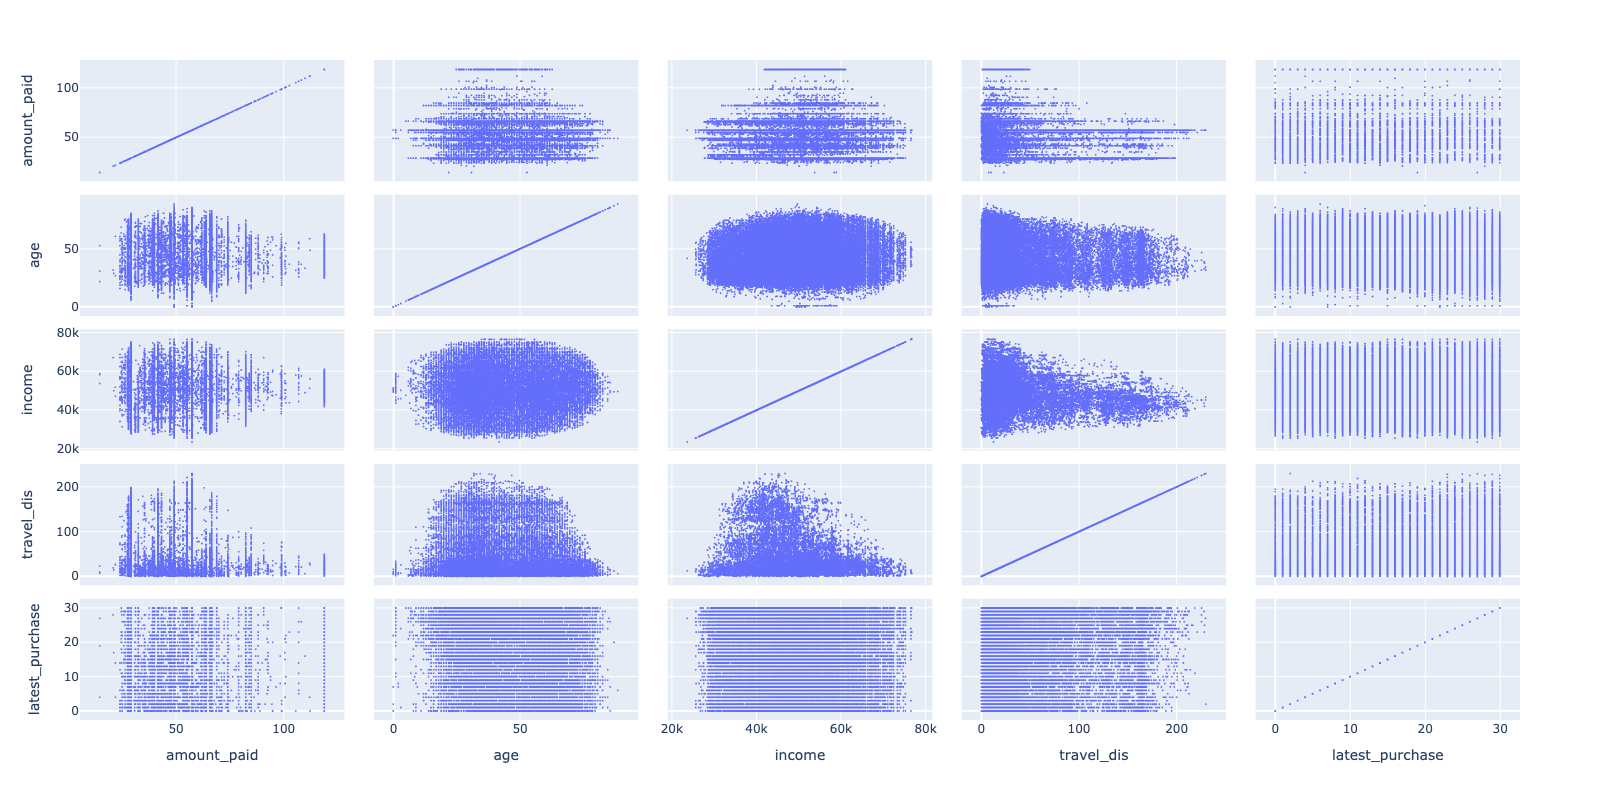

In [25]:
px.scatter_matrix(df, width=1600, height=800).update_traces(marker={"size":2}).show("png")

## Pre-Process Data

### Pre-Processing Pipeline

In [26]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# create a pipe line for numerical variables
preprocessor = Pipeline([            
    ('std_scaler', StandardScaler()),    
    ('pca', PCA(n_components= 3, random_state= 42))    
]).set_output(transform = "pandas")
preprocessor.fit_transform(df)

,pca0,pca1,pca2
0,-1.035939,1.732539,1.943924
1,0.411577,1.616140,0.345705
2,-1.525558,1.665571,1.721126
3,-0.321478,0.852247,-0.343475
4,-1.168908,1.915892,2.445290
...,...,...,...
67010,0.737854,1.165117,0.485951
67011,-0.524768,0.276122,1.928826
67012,0.721129,1.200334,0.241088
67013,0.094632,0.933964,1.797059


## Kmean Clustering

full pipe line

In [27]:
from sklearn.cluster import KMeans

pipe_test = Pipeline(
    steps= [        
        ('preprocessor', preprocessor),        
        ('kmeans', KMeans(random_state= 42))
        ]
    )

In [28]:
# if you dont want to define or add arguments to the model, we can do it by using parameter. model.set_params(**{})
from sklearn.metrics import silhouette_score
wcss1 = []
k_clusters=range(2,10)
for k in k_clusters:          
    pipe_test.set_params(**{ 
        "kmeans__init": 'k-means++', 
        "kmeans__n_clusters" : k ,
        "kmeans__n_init": 5,
         })
    model=pipe_test.fit(df)        
    wcss1.append(model['kmeans'].inertia_)
px.line(x=k_clusters, y=wcss1, width=1000, height=800).update_layout(xaxis_title = "k", yaxis_title= "intertia_score")

### Select Best kmeans = 5 clusters

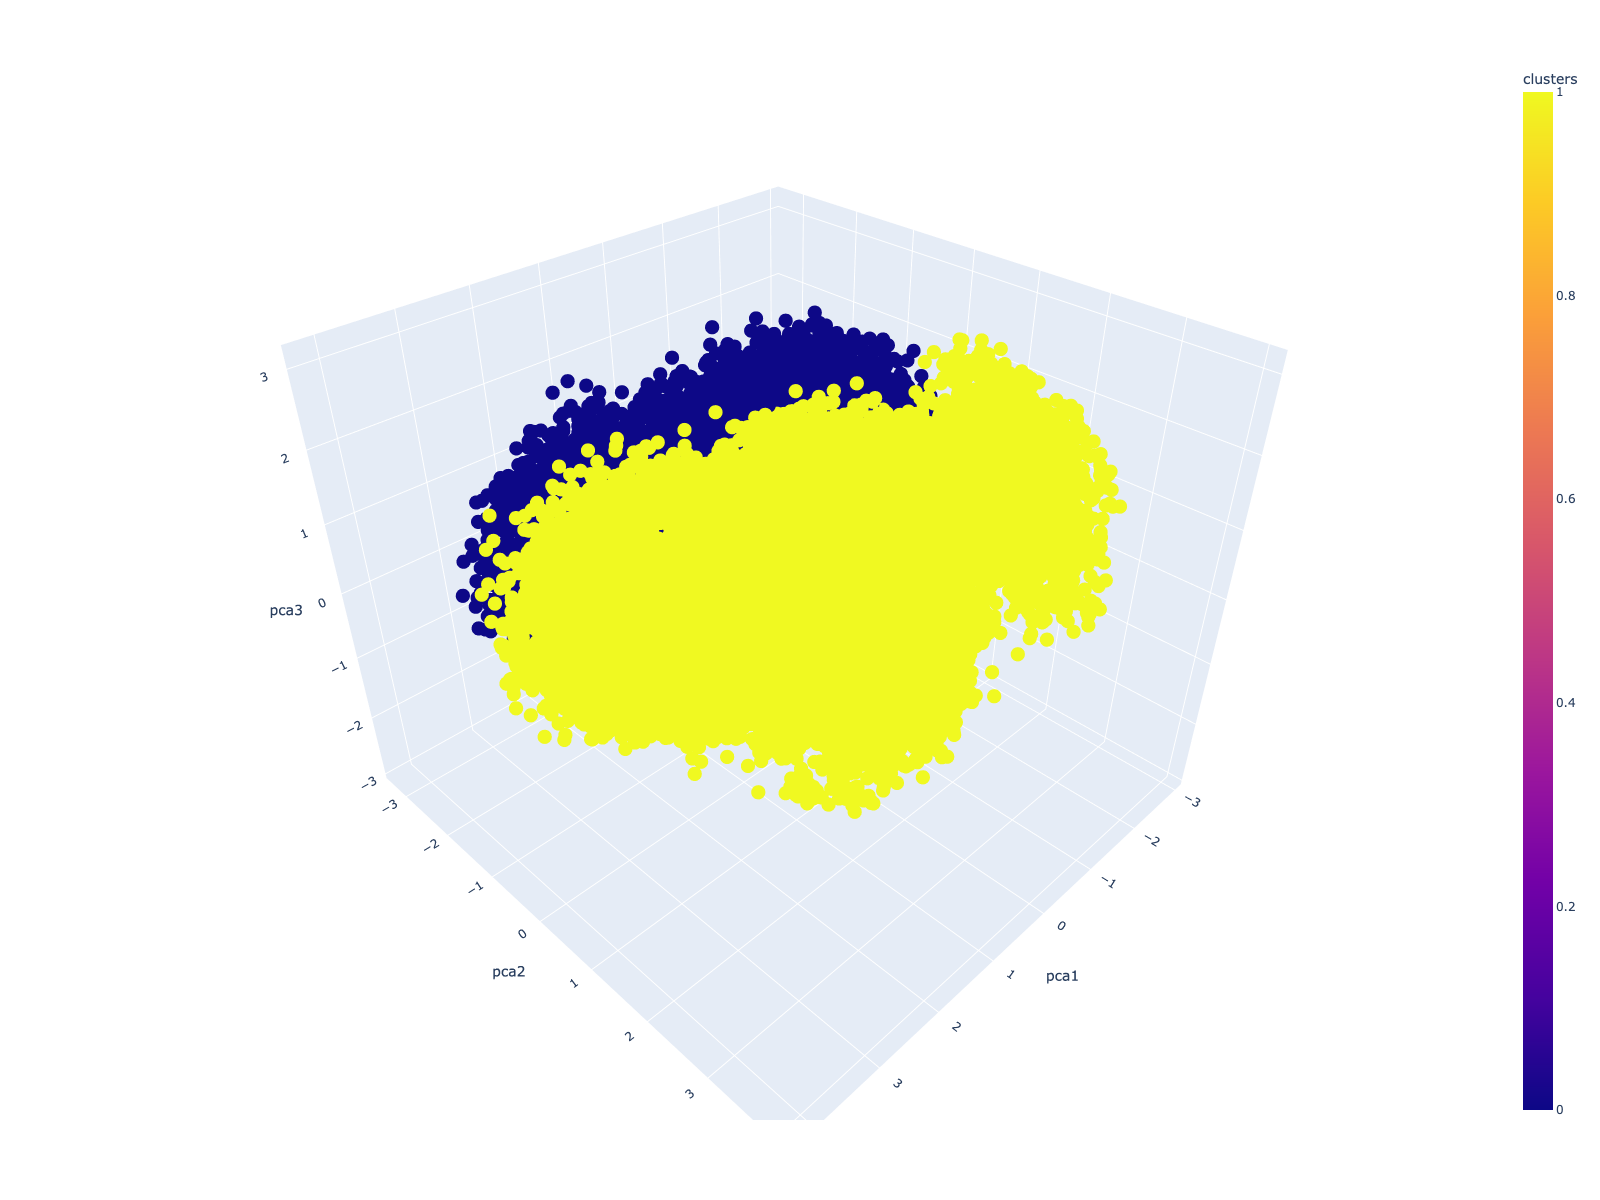

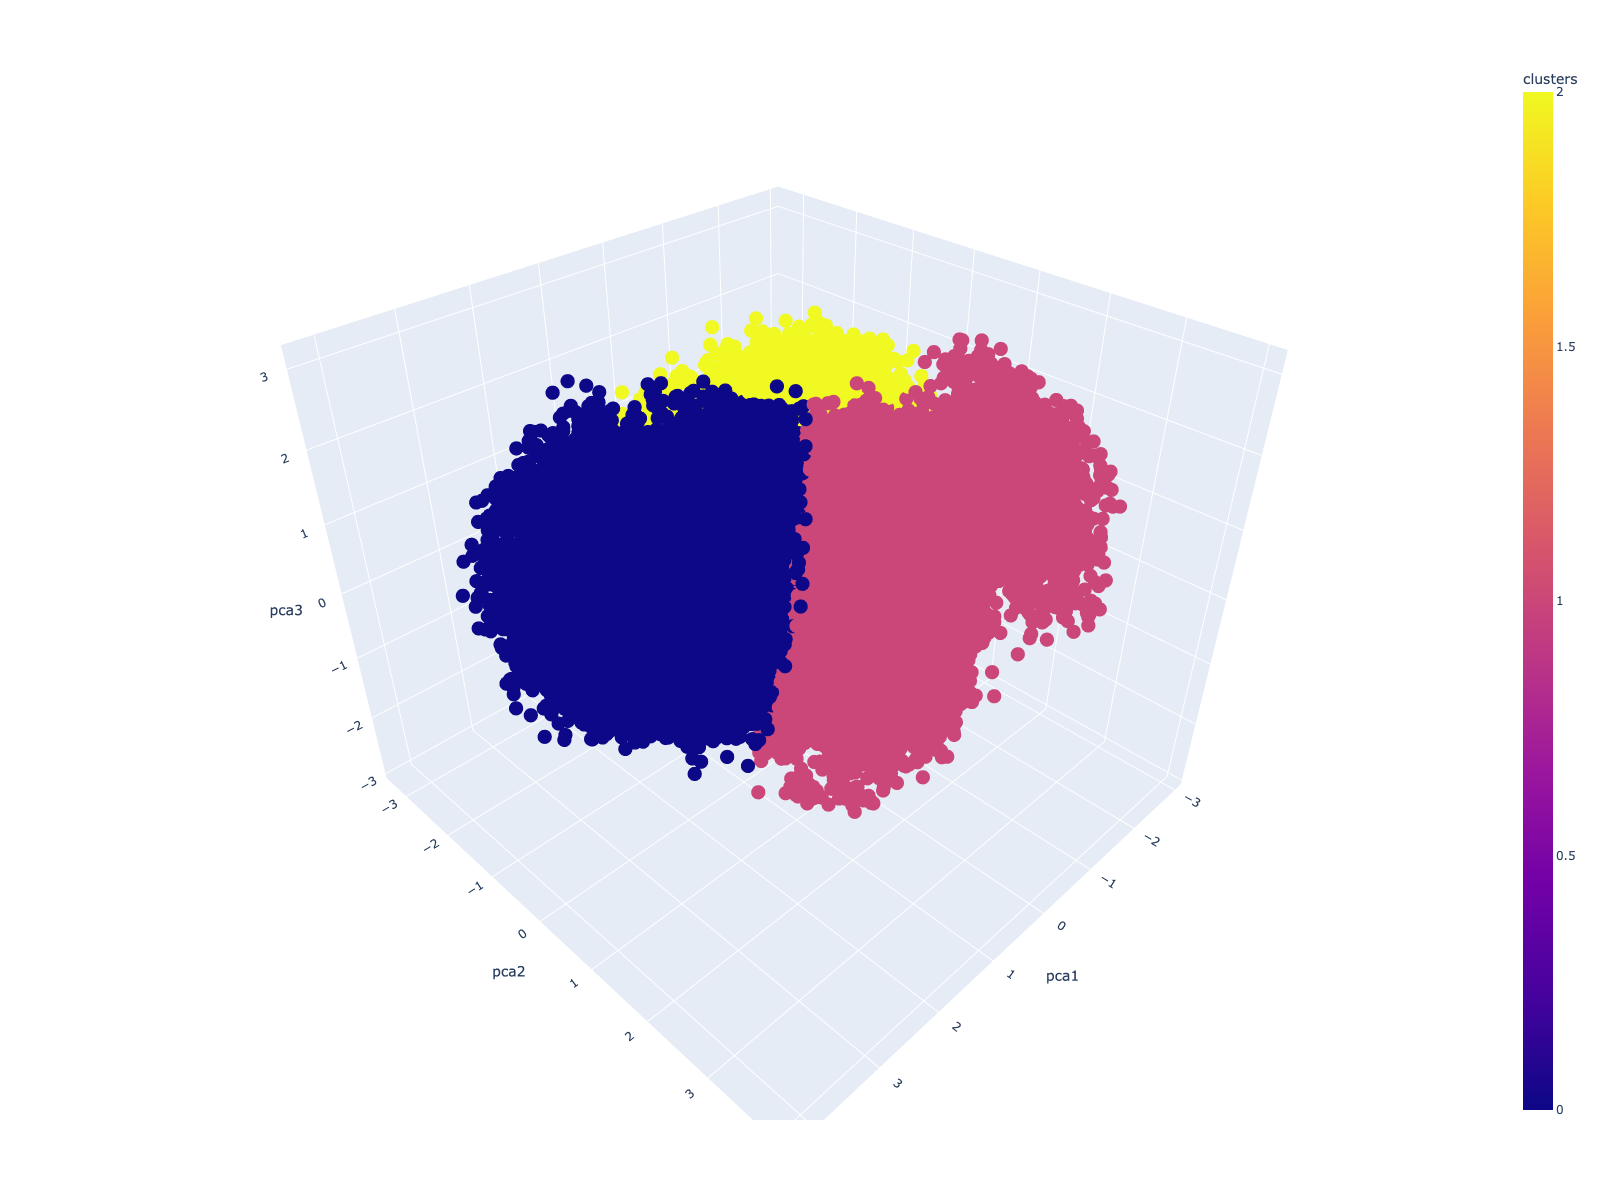

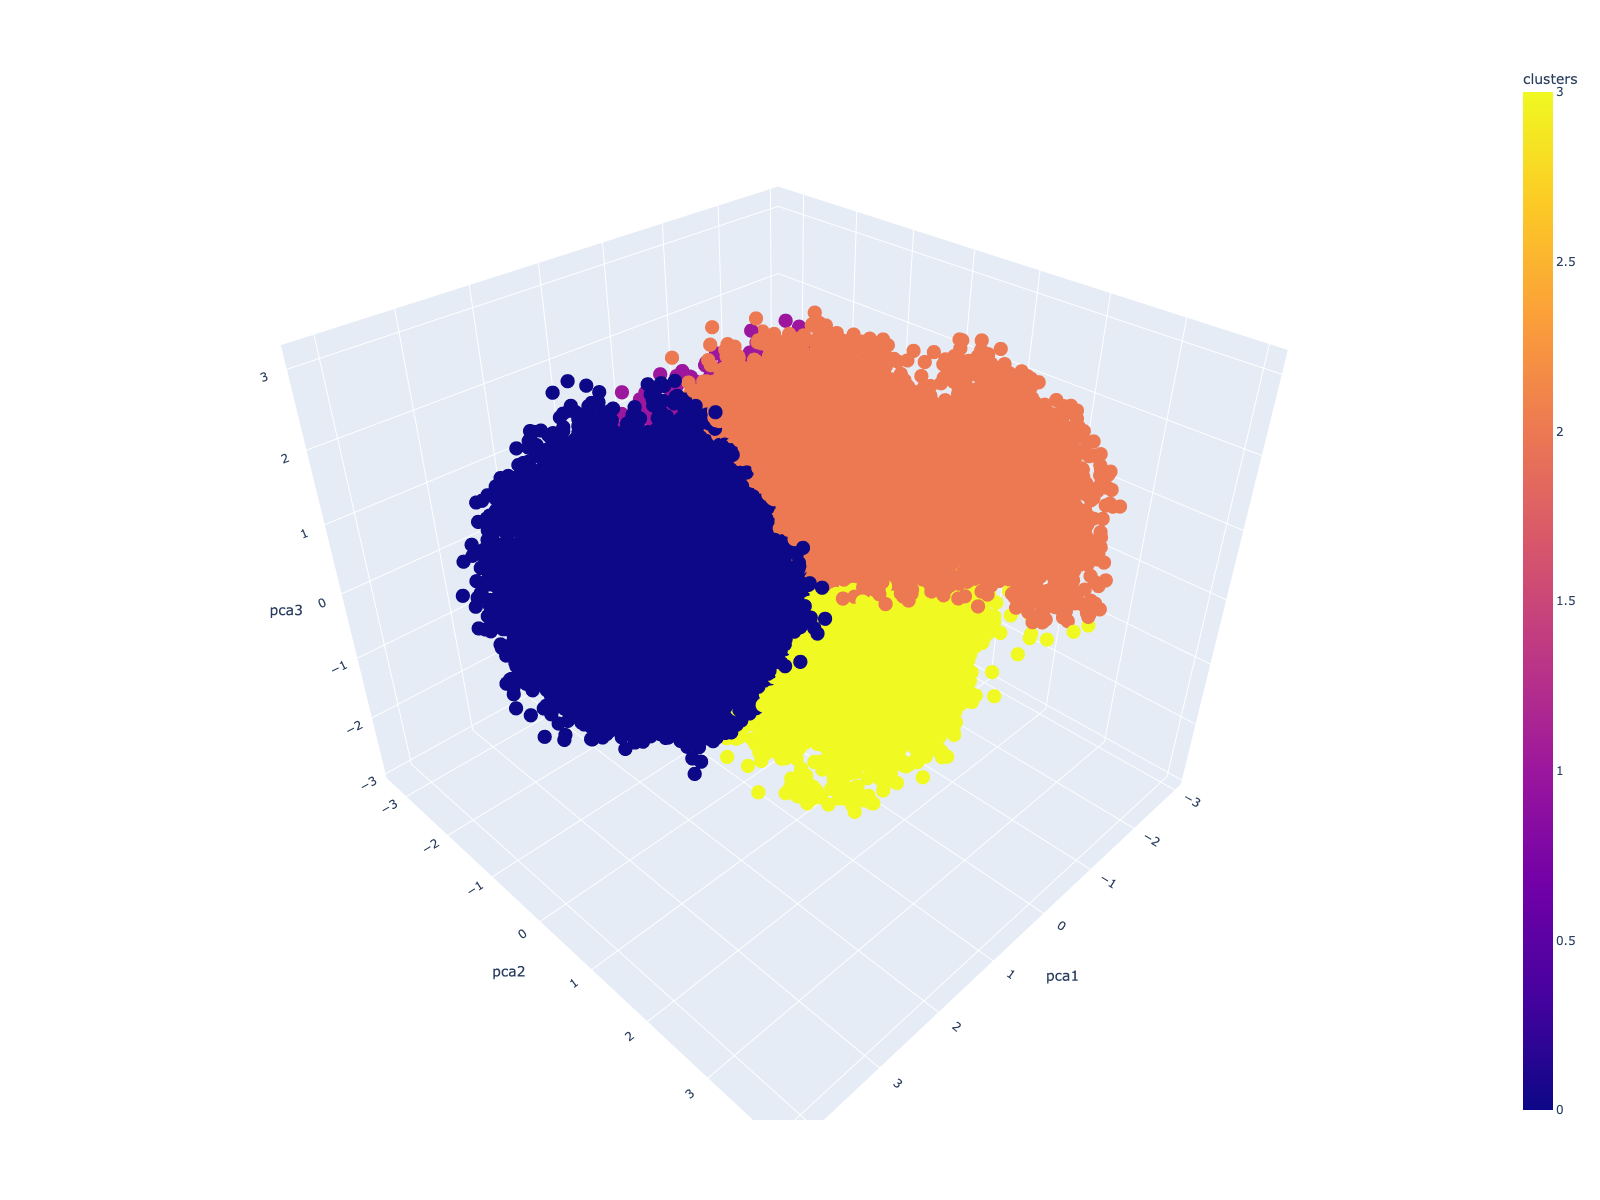

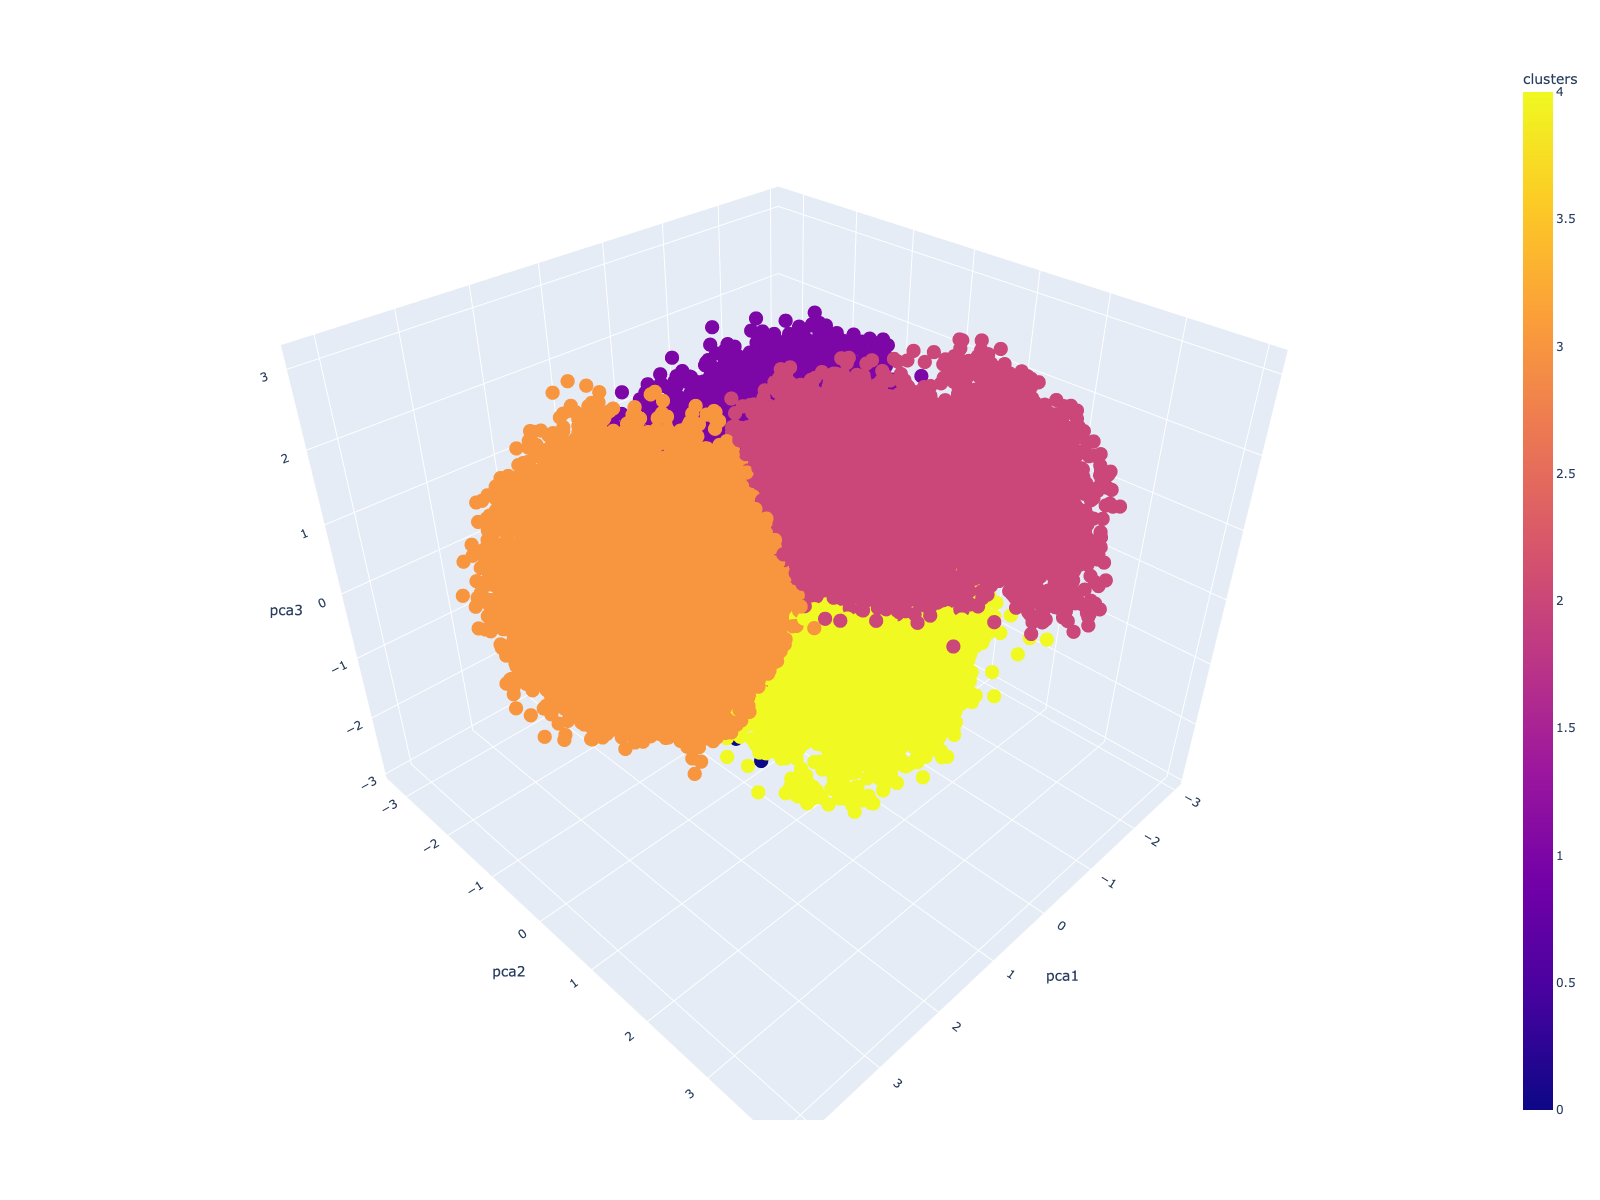

In [34]:
optimal_cluster= range(2,6,1)

for i in optimal_cluster:
    pipe_test.set_params(**{
        "kmeans__init": 'k-means++', 
        "kmeans__n_clusters" : i, 
        "kmeans__n_init": 10 , 
        "kmeans__max_iter": 1000000    
        })

    model= pipe_test.fit(df)        
    
    pca_vars= model['preprocessor'].fit_transform(df)
    
    results= pd.DataFrame()
    results['pca1'] = pca_vars.iloc[:, 0]
    results['pca2'] = pca_vars.iloc[:, 1]    
    results['pca3'] = pca_vars.iloc[:, 2]    

    results['clusters'] = pd.Categorical( model['kmeans'].labels_)
    #pca_vars, model['kmeans'].cluster_centers_[:,1]
    results= results.merge(pd.DataFrame(model["kmeans"].cluster_centers_).mean(axis=1).reset_index(name="centres").rename(columns={"index":"clusters"}) ,
    how= "left",
    on= "clusters")
    px.scatter_3d(results,x='pca1', y='pca2', z='pca3',color='clusters', width=1600, height=1200).show("png")
    

### attach clusters to the original data

In [31]:
df_clusters =df.copy()
df_clusters["clusters"]= model['kmeans'].labels_
df_clusters.head()

,amount_paid,age,income,travel_dis,latest_purchase,clusters
0,119.0,38.75,49425.0,6.815,2.0,2
1,69.0,40.00,51100.0,38.160,30.0,4
2,119.0,43.00,58000.0,18.470,1.0,2
3,57.5,38.00,54850.0,11.690,22.0,4
4,119.0,51.00,50200.0,14.450,8.0,2


# Visulise the clusters

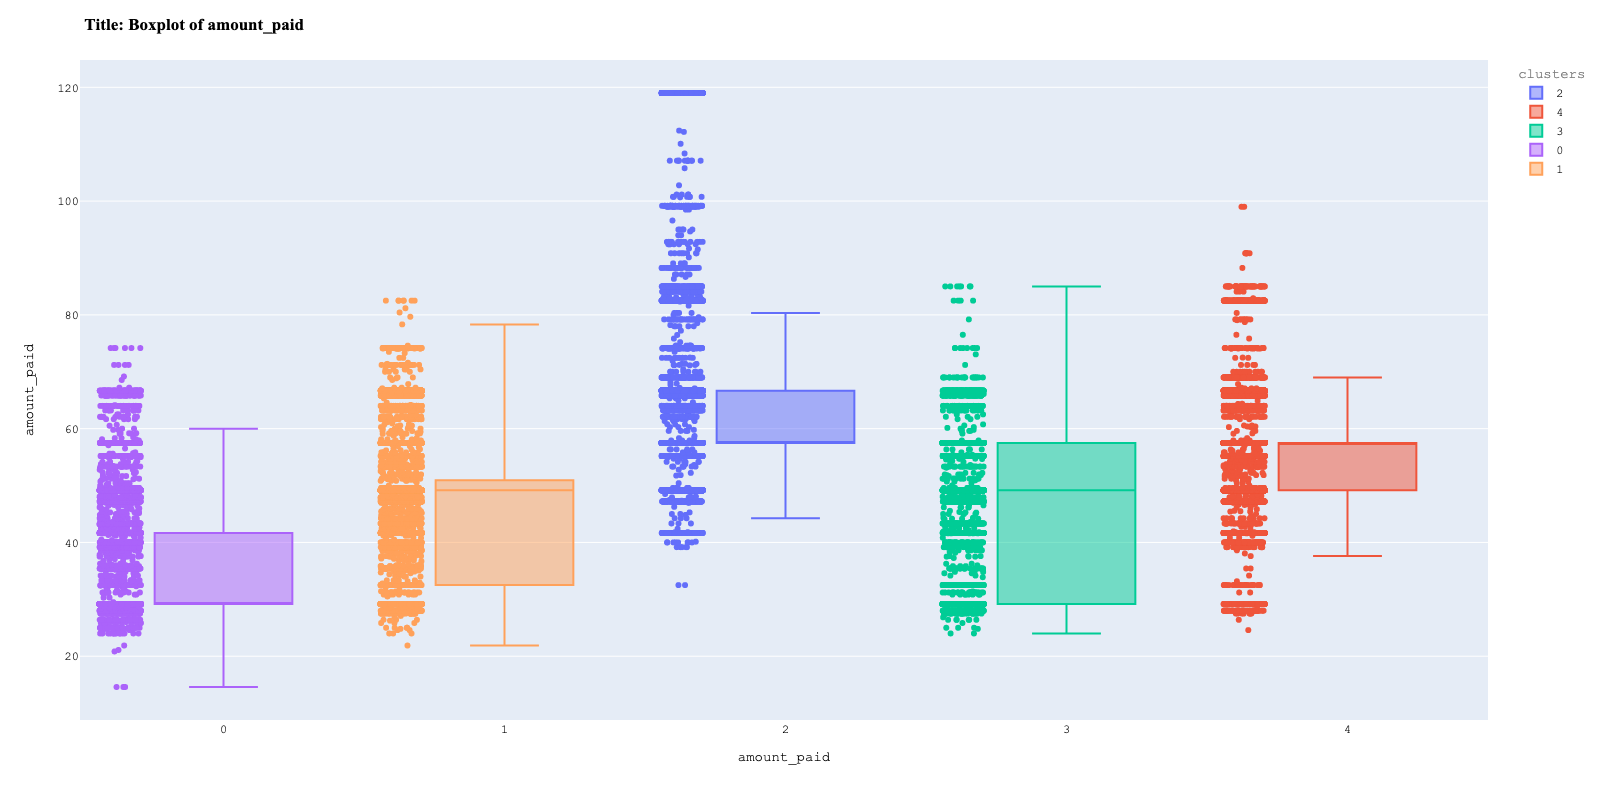

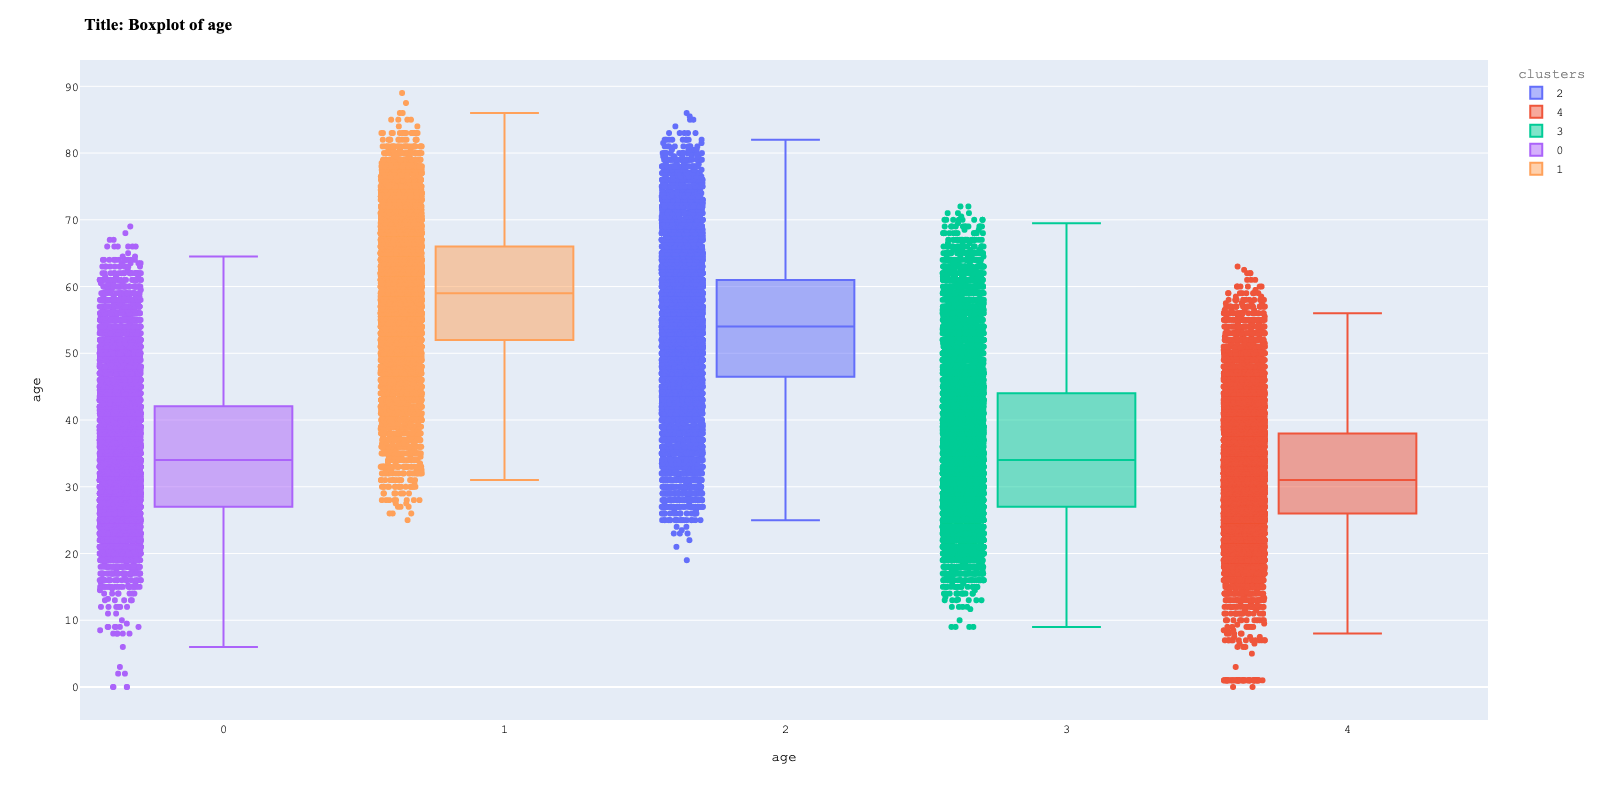

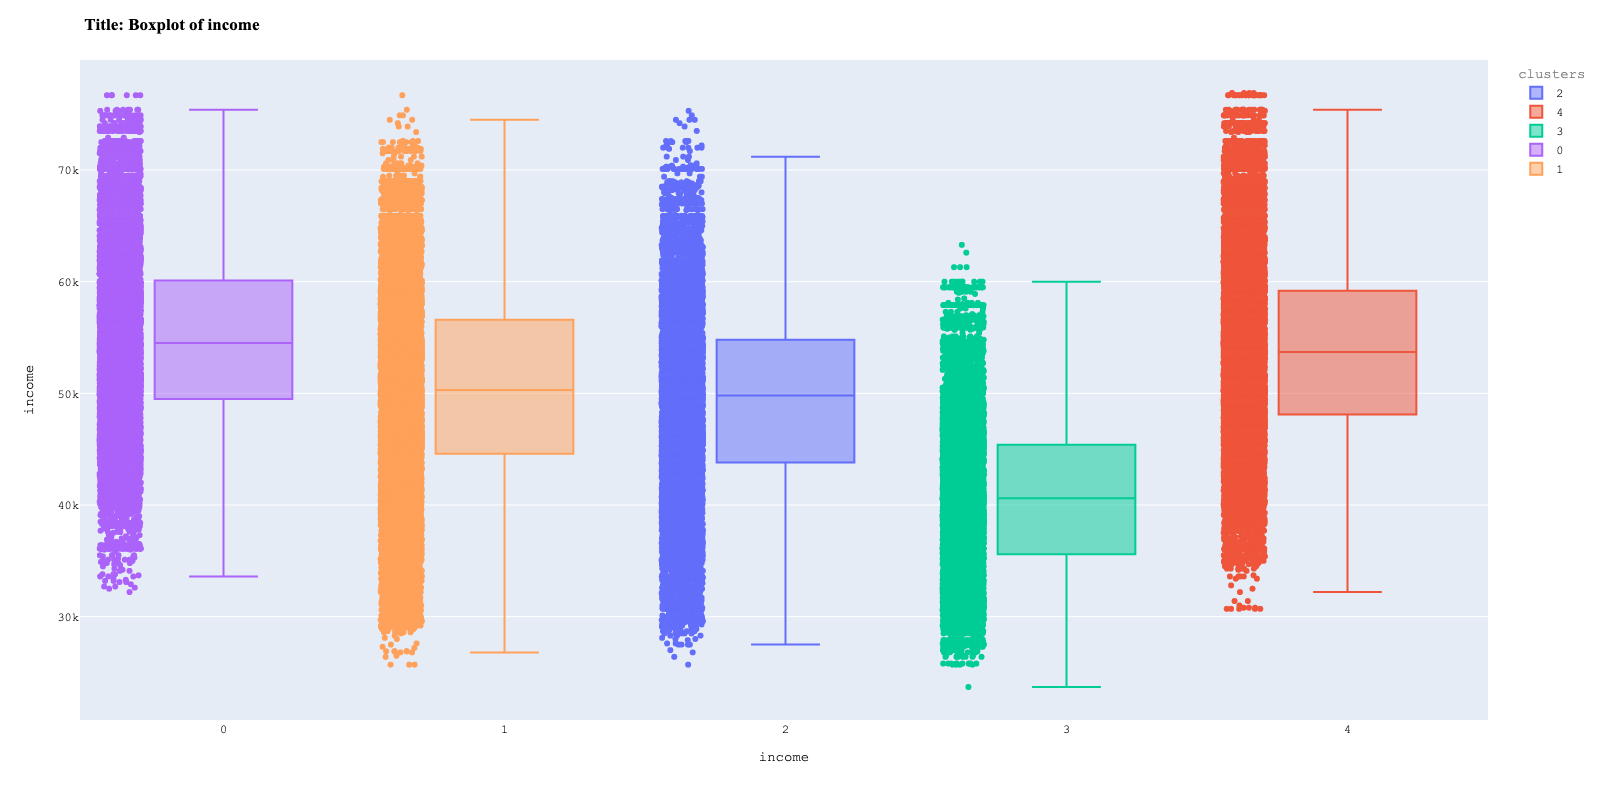

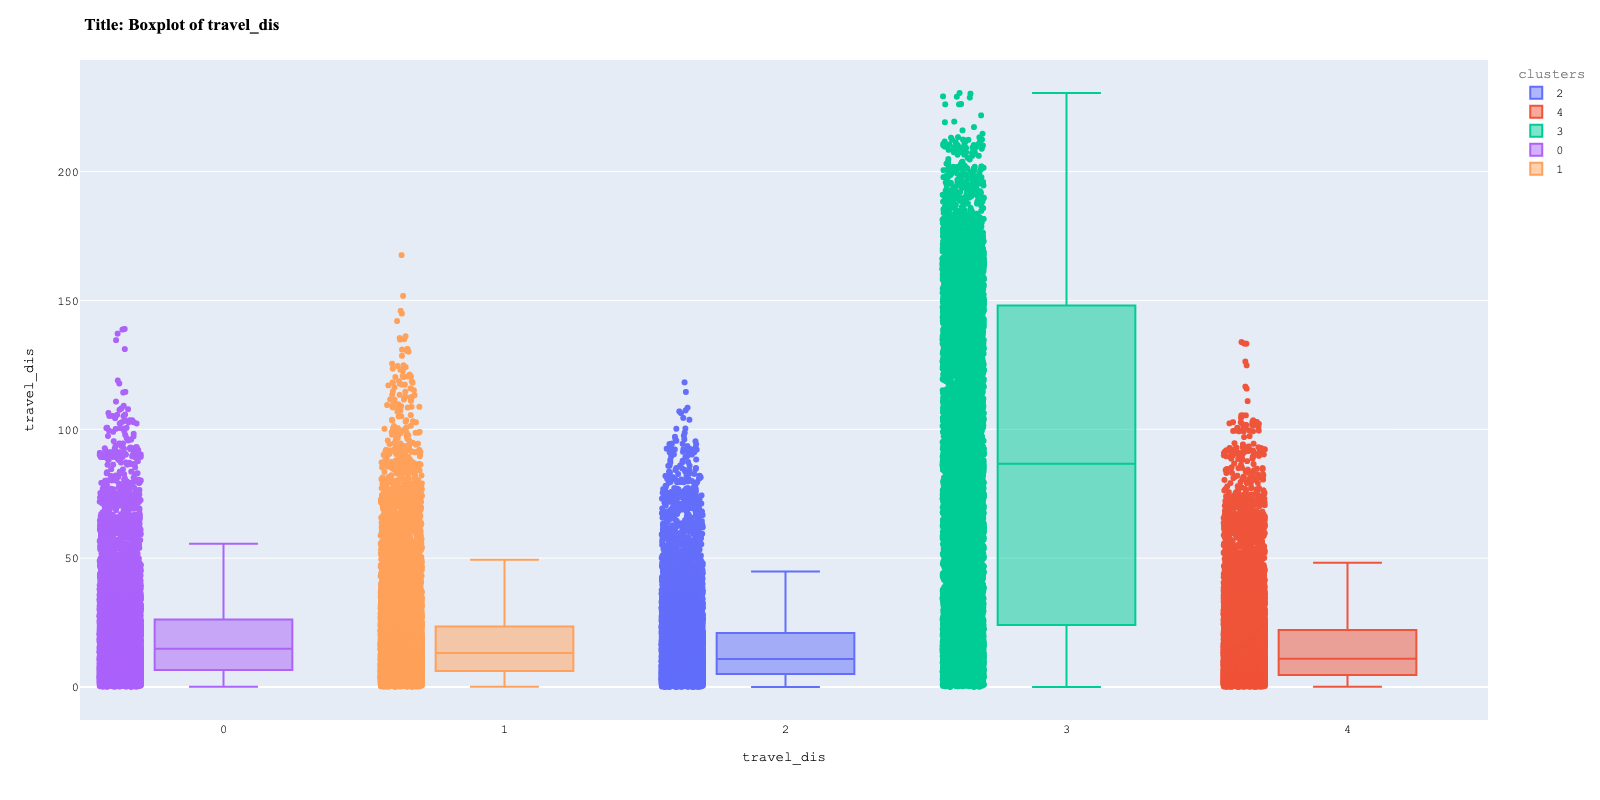

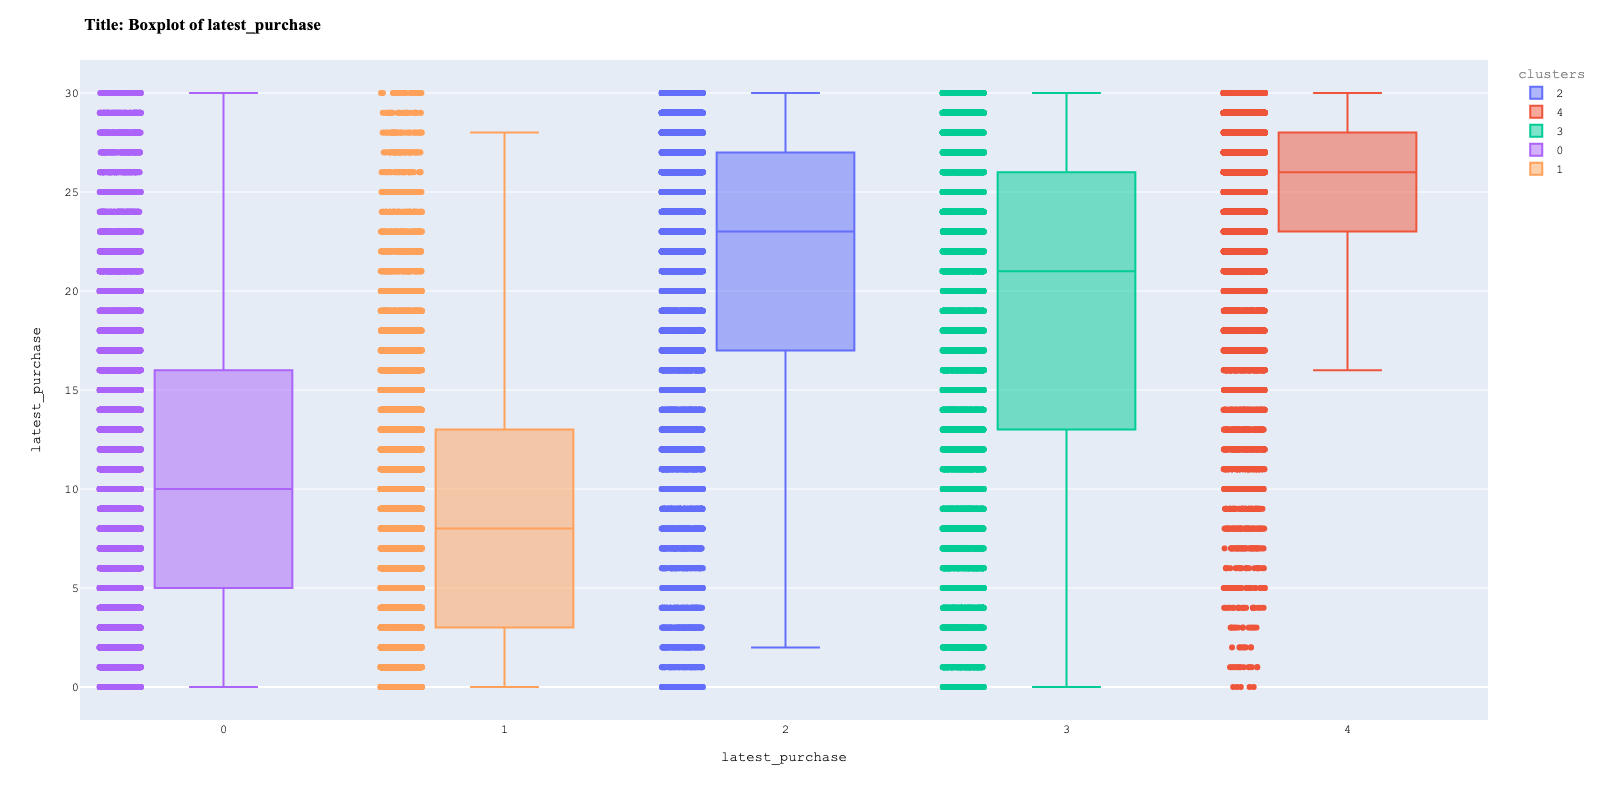

[None, None, None, None, None]

In [32]:
def plot_box(var):
    p=(    
        df_clusters
        .plot.box(x="clusters",y=var, color="clusters", width= 1600, height= 800, points="all")   
        .update_layout(
            #bargap=0.1,
            title = "<b> Title: Boxplot of {} </b>".format(var),
            xaxis_title = var,                       
            font_family="Courier New",
            font_color="black",
            font_size = 12,
            title_font_family="Times New Roman",
            title_font_color="black",        
            legend_title_font_color= "grey"
            )        
    )
    return p.show("png")

list(
    map(
        plot_box, df_clusters.columns[~df_clusters.columns.isin(["clusters"])]
        )
    )
    

In [33]:
(
    df_clusters
    .groupby(['clusters'])
    .describe()    
).T.reset_index().query("level_1.isin(['count', 'mean', 'std', 'min', 'max']) ")
    


clusters,level_0,level_1,0,1,2,3,4
0,amount_paid,count,12513.000000,13332.000000,12228.000000,11544.000000,17398.000000
1,amount_paid,mean,35.789562,46.161491,67.793332,46.428374,55.439061
2,amount_paid,std,9.663443,12.320977,20.651984,12.604496,8.561407
3,amount_paid,min,14.590000,21.880000,32.500000,24.000000,24.590000
7,amount_paid,max,74.170000,82.500000,119.000000,85.000000,99.000000
8,age,count,12513.000000,13332.000000,12228.000000,11544.000000,17398.000000
9,age,mean,35.340543,58.779028,53.832947,36.384580,31.921676
10,age,std,10.234018,9.932248,11.189748,11.809463,8.753047
11,age,min,0.000000,25.000000,19.000000,9.000000,0.000000
15,age,max,69.000000,89.000000,86.000000,72.000000,63.000000
